# Chapter 4: Charlie signs in to his Petflix account

### Quick Start

If you are in the colab environment, please follow the steps below:

Step 1: Click Runtime -> Run all to run the notebook.

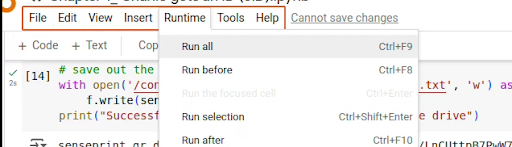

Step 2: You will be prompted to give permission to access your Google Drive files, which is essential for the notebook to save intermediate results. Please click on "Connect to Google Drive".

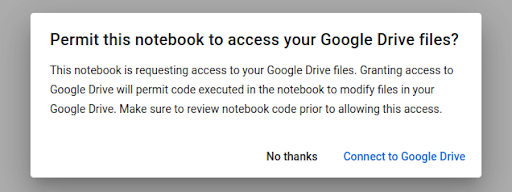

Step 3: Please click on "Run anyway" to run the notebook!

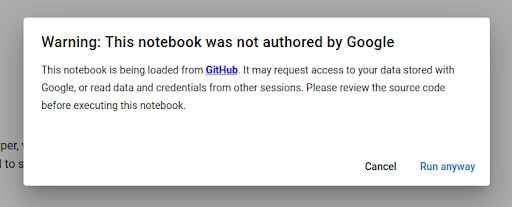

As an alternative to run all cells, you can also run cell by cell and give aforementioned permissions when prompted!

### 4.1 Overview
1. [Chapter 1_ Charlie gets an ID (eID)](https://colab.research.google.com/github/Seventh-Sense-Artificial-Intelligence/SenseCrypt-Walkthrough/blob/main/Chapter%201_%20Charlie%20gets%20an%20ID%20(eID).ipynb)
1. [Chapter 2_ Charlie wants a loan (eID)](https://colab.research.google.com/github/Seventh-Sense-Artificial-Intelligence/SenseCrypt-Walkthrough/blob/main/Chapter%202_%20Charlie%20wants%20a%20loan%20(eID).ipynb)
1. [Chapter 3_ Charlie signs up for Petflix (FacePKI)](https://colab.research.google.com/github/Seventh-Sense-Artificial-Intelligence/SenseCrypt-Walkthrough/blob/main/Chapter%203_%20Charlie%20signs%20up%20for%20Petflix%20(FacePKI).ipynb)
1. [Chapter 4_Charlie_signs into Petflix (FacePKI)](https://colab.research.google.com/github/Seventh-Sense-Artificial-Intelligence/SenseCrypt-Walkthrough/blob/main/Chapter%204_Charlie_signs%20into%20Petflix%20(FacePKI).ipynb)
1. [Chapter 5_Petflix sends Charlie a catbond meme (FacePKI)](https://colab.research.google.com/github/Seventh-Sense-Artificial-Intelligence/SenseCrypt-Walkthrough/blob/main/Chapter%205_Petflix%20sends%20Charlie%20a%20catbond%20meme%20(FacePKI).ipynb)
1. [Chapter 6_Charlie decrypts catbond meme (FacePKI)](https://colab.research.google.com/github/Seventh-Sense-Artificial-Intelligence/SenseCrypt-Walkthrough/blob/main/Chapter%206_Charlie%20decrypts%20catbond%20meme%20(FacePKI).ipynb)

### 4.2 Introduction

In this chapter, we shall see how Sensecrypt can fully address the second problem: Secure login. Petflix loses billions of dollars in revenue annually because of multiple users logging in to the same account. It needs to ensure that only Charlie is logging in to his own account, and ensure his privacy at the same time. <br><br>


Recall that in the previous Chapter, Charlie's Face Certificate has been generated by the Government (Trusted Issuer) and then securely sent and stored in the Petflix servers. Both the Government and Petflix stores Charlie's Face Certificate. Upon pressing the login button on the Petflix website, Charlie is presented with a QR code to scan with his mobile phone using the Government mobile app (build on top of the sensecrypt SDK). The QR code represents a temporary `transaction_id` which needs to be signed by Charlie using his face ,via the Government mobile app.<br><br>


Petflix can then verify that the `transaction_id` has been signed by Charlie using his Face Certificate (generated by Government, stored in Petflix servers). Now, let's go behind the scenes of the SenseCrypt mobile SDK to see what is actually happening.<br><br>

**Flow of Events:**
1. User scans the QR code in the email with Trusted Issuer (Government) mobile app to get the transaction_id.
1. User scans his face with the Trusted Issuer mobile app.
1. Trusted Issuer signs the transaction_id with the user's face, his SensePrint, and the correct purpose_id.
1. Trusted Issuer (Government) sends the signed transaction_id to the Verifier (Petflix).
1. The Verifier (Petflix) verifies the signed signature by sending a request to the Sensecrypt server, with Charlie's Face Certificate and the signed transaction_id.
1. The Sensecrypt server returns that the signed signature is verified.
1. Verifier (Petflix) can now confirm that it is the actual user that signed the transaction_id.

Note that only the Trusted Issuer sees the user's face. The Verifier does not access the biometric data of the user throughout the whole process. <br><br>


*Note: Custom apps can be built on top of the SenseCrypt mobile SDK to access the SenseCrypt server API endpoints. What is shown here are the raw API calls made through the SenseCrypt mobile SDK in order to aid your understanding of the overall process flow.*

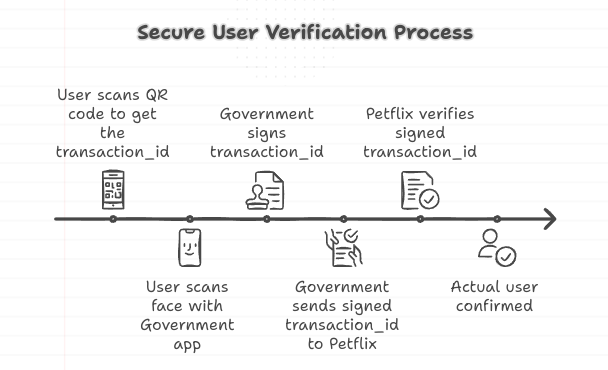

### 4.3 Pre-run cells

In [1]:
# **********************************INPUT************************************#
# Please provide the url of the SenseCrypt server and the associated api key.#
# ***************************************************************************#
url = "https://apiserver.sensecrypt.com/"
api_key = "BjeaACQczWh5Xw5sIEE0mBu1mpCnfOfmM47PT67f7mw="

In [2]:
# Run these functions, which will be used later in the notebook
from io import BytesIO
import base64
import requests
import cv2
import matplotlib.pyplot as plt
from PIL import Image

using_colab = True
try:
    # mount your private google drive for saving and loading out artifacts to be used in subsequent notebooks
    from google.colab import drive
    drive.mount('/content/drive')
except ImportError:
    print("Not in Google Colab. Assume running in the local environment and not accessing google drive storage.")
    using_colab = False
    import os

def call_sensecrypt_server(api_key, data, endpoint, url):

  full_url = url + endpoint

  # Prepare headers
  headers = {
      "x-api-key": api_key,
      "Content-Type": "application/json"
  }

  # Send POST request
  response = requests.post(full_url, json=data, headers=headers)

  # Check the response status and content
  if response.status_code == 200:
      print("Request was successful")
      return response  # Return JSON data if the request was successful
  else:
      print(f"Request failed with status code: {response.status_code}")
      print(response.text)  # Print the raw response content
      return None

def convert_image_to_base64(image, format="JPEG"):

  # Save the image as a byte stream in memory
  buffered = BytesIO()
  image.save(buffered, format=format)  # Default format is 'JPEG', can be changed
  img_bytes = buffered.getvalue()

  # Convert byte stream to Base64
  img_base64 = base64.b64encode(img_bytes).decode('utf-8')

  return img_base64

def fetch_image(image_url):
  response = requests.get(image_url)
  img = Image.open(BytesIO(response.content))
  return img

Not in Google Colab. Assume running in the local environment and not accessing google drive storage.


In [3]:
import hashlib

# Scan the QR code to get the `transaction_id` and convert to SHA256 base 64
transaction_id = "0x1234567890abcdef" # example transaction_id
data = transaction_id.encode('utf-8')
sha256_hash = hashlib.sha256(data)
sha256_base64 = base64.b64encode(sha256_hash.digest()).decode('utf-8')

# Scan the face to get the face_base_64
# Load the image from file.
# In actual implementation, this will be the image captured by the user using the phone camera
if using_colab:
    uploaded_face_image = fetch_image("https://raw.githubusercontent.com/Seventh-Sense-Artificial-Intelligence/SenseCrypt-Walkthrough/refs/heads/main/images/JohnnyDepp_2.jpg") # Replace with the path to your image file
else:
    uploaded_face_image = Image.open("./images/JohnnyDepp_2.jpg")
img_base64 = convert_image_to_base64(uploaded_face_image)
print("img_base_64:", img_base64)

img_base_64: /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAMABAADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwC4R1Oc0zqcZHBqRiM9PxNNcAEEEenArzVufRszbsYRl6Cs1zjA4wfxrTu8HIA4xjB/xrMbGSMYxwMmuiK0OWoMPUnA6Ub8KBgcnJIpDk5ORjGOe49aRVOMe/WrMNbgSWzTsjrj2/CggHhTyOSDTQMbiT780rD

In [4]:
# get the senseprint from the server
# Here, we simulate by loading the senseprint from a file
if using_colab:
    senseprint_path = '/content/drive/MyDrive/senseprint_qr_data.txt'
else:
    senseprint_path = './temp/Chapter1/senseprint_qr_data.txt'
    assert os.path.exists(senseprint_path), 'SensePrint QR data does not exist! Please generate the qr data by running the chapter 1 notebook :)'


senseprint_base_64 = open(senseprint_path, 'r').read()
print("senseprint_base_64:", senseprint_base_64)

# Set the correct purpose_id which should be the same as the associated Face Certificate
purpose_id = "for_petflix_login_and_decryption"

# Call the /face-sign endpoint
data = {
    "data_sha256_base_64": sha256_base64,
    "face_base_64": img_base64,
    "purpose_id": purpose_id,
    "senseprint_base_64": senseprint_base_64,
}

endpoint = "/face-sign"
response = call_sensecrypt_server(api_key, data, endpoint, url)

ecdsa_der_signature_base_64 = response.json()['ecdsa_der_signature_base_64']
print("ecdsa_der_signature_base_64:", ecdsa_der_signature_base_64)

senseprint_base_64: ApiBrQakACi6TZNNwJhDjtmDkvjWSewfiTY72rs3IVI+8g3l6sDheWxfi+A8zxRkQD2OckLMMfobbRSEmtWO+VRIO21JPYB18NV/MfLgmrjZrfqihqj+tuwYwhtRGD4kZoygdtkOAtpJGouSQv87nqYZKOH3V8sJ/kDOl1fCVHZhYnisnKP10TPSFo6cfVGtw28167iAjdeO4+CutWwYeckLSNU+vQ7c95LKLgc/hyc71x1+zmcNQ/2Gy/0MTtLQrxKKk82H0AjcDGstbjW2vFl4NNTk/WAZXsBOn4rpRauKgwN06xoQ738QSEBvKTFBmTngYcUytAw/vRCmvvxqz6QDGIi3PCfjejlGOhsOgZBr2+/9YpLeqHSwiOCpIOJuA89bZTHBirLzR62kQtUAagz0H8795x3Qa8siLxMpPTVneHfeWCorTHmxA2kgE7UZ52Q76rw+0jAE56ZkptnE7mJxdf4+QvQm33R8BiQIZizQgcCc/q6aXEyHGKn6JWq8CAKd20HUjftigVXOMrf8AOUpQSB5UKzLOxYKX6lhbOZedQIMmhBp0P+GZuAq3392o5V8F1IFaLOz0c458z4HrbFfXN9n8h9twer7cOA6HoaNhMIyVCf+Hc/wlkThKK0NHKiFeR9YIXrm2L2AMEGXbZWsIdj5/BYOwnhjjjjEC9Tax32YqVYyQAwOZCOiCcHggkDCoy6UFZ/SXND03kUg2hmIoZjZOqE87e4Aktb2XT5KNmEZN613uvCM2iSl618D9NUH8Mlg
Request was successful
ecdsa_der_signature_base_64: MEYCIQDGPg7l7VlqHFNG5/59jqDWzLuIrbAkMv9xolCPaRPkSgIhAPFef4fNhz5ADEzLKptmLFiMOcaGFIXOD+cmu+1vMGLp


### 4.4 Using the `/verify-face-signature` API Endpoint [(Link to documentation)](https://docs.sensecrypt.com/sensecrypt-v3.1.1/sensecrypt-server/sensecrypt-face-pki/face-signature-verification)

Now that the `transaction_id` has been signed to produce the correct `ecdsa_der_signature_base_64` signature, Petflix would need to check that the face signature is actually legitimate. It will do this using the `/verify-face-signature` endpoint. Let's see how this is done.

In [5]:
# From the Petflix side...

# Retrieve the face_certificate_pem
# Note that this face certificate has earlier been stored in the Petflix database
if using_colab:
    face_cert_path = '/content/drive/MyDrive/face_cert.pem'  
else:
    face_cert_path = './temp/Chapter3/face_cert.pem'
    assert os.path.exists(face_cert_path), 'Face certificate does not exist! Please generate the certificate by running the chapter 3 notebook :)'

face_cert = open(face_cert_path, 'r').read()
print("face_cert:", face_cert)

data = {
    "data_sha256_base_64": sha256_base64,
    "ecdsa_der_signature_base_64": ecdsa_der_signature_base_64,
    "face_certificate_pem": face_cert,
}

endpoint = "/verify-face-signature"

response = call_sensecrypt_server(api_key, data, endpoint, url)
print("response:", response.json())


face_cert: -----BEGIN CERTIFICATE-----
MIICXjCCAgSgAwIBAgIRAPGlGkF7fsf3BjeW+RG3KJEwCgYIKoZIzj0EAwIwSDFG
MEQGA1UEAww9U2Vuc2VDcnlwdCBDdXN0b21lciBJRCAoYTZiNDQ5MzQtN2Q0Yi00
OWFlLWI4MjQtMDBmZWQ2MjU1ZmY2KTAeFw03MDAxMDEwMDAwMDBaFw0zNDEwMDEw
MDAwMDBaMCkxJzAlBgNVBAMMHmNoYXJsaWVfY3J5cHRvZnNvbkBleGFtcGxlLmNv
bTBWMBAGByqGSM49AgEGBSuBBAAKA0IABH/LdqeOluQBQBJssuo01MZMFr+rhRQf
7aMt0qqHQ/rr247QHIxxt/52tMmUTwHyJIZt6LsbilkZrTOcYw5lygajgfAwge0w
DgYDVR0PAQH/BAQDAgWgMIHaBgoqhT4Ah3QBAQEABIHLAs81kKhZYimRYfjF4oFG
880VOaIVxFBIMe4pL6+CeSWPmXiOW56UzKUVJxfHpRacNL3UvGu9BH9lkEqy+Tyg
j647/BKbqpXlKVr3iJNanPelKyZW0XiM5u6RWwz+dVJdtUNJEnNU90x9rxr9qZNk
yHbUIRVvkA0yChSB7hLVPCGqMK2/B32+S6Q2PdpizsD136LXRN5XgUqWXyuxRlR6
x0Cg9wnnDJXlfqRZQHKMWYivlJS1EyjXQFnf4XRJ9Q/2ovJeUcBWahM+ymYwCgYI
KoZIzj0EAwIDSAAwRQIgBPm+vguS/++PajRX2D9GXsUSIsX0JGqG0qMW90c2jmEC
IQDs5J9+bMTvQQq8wk+tMrk4TxygLR+zwuS5367e0/LS4w==
-----END CERTIFICATE-----

Request was successful
response: {'is_valid': True}


**Verified Secure Login**

> As seen, the response from the Sensecrypt server shows that the signed transaction_id is actually valid. Now, Petflix can be sure that the person signing in to Charlies Petflix account is actually Charlie himself. Also, Charlie's privacy and biometric data has been fully protected as well. Petflix does not have any information related to Charlie's face or biometrics.

### 4.5 Welcome to Petflix

**“Welcome to Petflix, Charlie! Your Face Certificate has been successfully verified.”**

Charlie beamed with excitement. He had unlocked a world of endless animal adventures. From majestic lions in the Serengeti to cuddly hamsters in cute short films, Petflix’s content library was at his fingertips.

He quickly settled into his favorite chair, grabbed some popcorn, and started browsing through the catalog. First up on his list? A heartwarming documentary on sea otters.

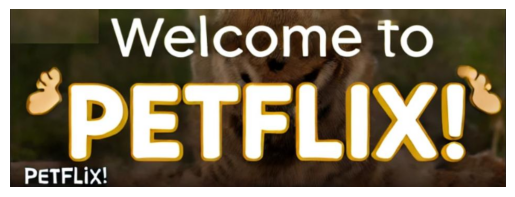

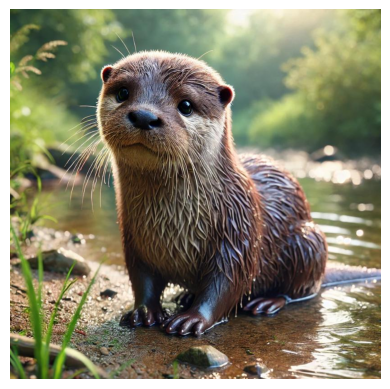

In [6]:
if using_colab:
    img_petflixlogo = fetch_image("https://raw.githubusercontent.com/Seventh-Sense-Artificial-Intelligence/SenseCrypt-Walkthrough/refs/heads/main/images/petflix_logo.jpg")
else:
    img_petflixlogo = Image.open("./images/petflix_logo.jpg")
plt.imshow(img_petflixlogo)
plt.axis('off')
plt.show()

if using_colab:
    img_otter = fetch_image("https://raw.githubusercontent.com/Seventh-Sense-Artificial-Intelligence/SenseCrypt-Walkthrough/refs/heads/main/images/otter.jpg")
else:
    img_otter = Image.open("./images/otter.jpg")

plt.imshow(img_otter)
plt.axis('off')
plt.show()

Continue on to Chapter 5: Petflix sends Charlie a catbond meme [here](https://colab.research.google.com/github/Seventh-Sense-Artificial-Intelligence/SenseCrypt-Walkthrough/blob/main/Chapter%205_Petflix%20sends%20Charlie%20a%20catbond%20meme%20(FacePKI).ipynb)!